In [3]:
!apt-get update
!apt-get install -y cmake build-essential pkg-config

!git clone https://github.com/opencv/opencv.git
!git clone https://github.com/opencv/opencv_contrib.git

!mkdir -p opencv/build
%cd opencv/build
!cmake -D CMAKE_BUILD_TYPE=RELEASE \
        -D CMAKE_INSTALL_PREFIX=/usr/local \
        -D OPENCV_ENABLE_NONFREE=ON \
        -D OPENCV_EXTRA_MODULES_PATH=../../opencv_contrib/modules \
        -D BUILD_EXAMPLES=OFF ..
!make -j8
!make install


Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pack

# STEP 1 Load Two Images

In [6]:
!pip install  opencv-python
!pip install  opencv-contrib-python
import cv2
import matplotlib.pyplot as plt

In [11]:
# Load two images
image1 = cv2.imread('/content/image1.jpg', 0)  # Replace with your actual image paths
image2 = cv2.imread('/content/image2.jpg', 0)


# Step 2: Extract Keypoints and Descriptors Using SIFT, SURF, and ORB

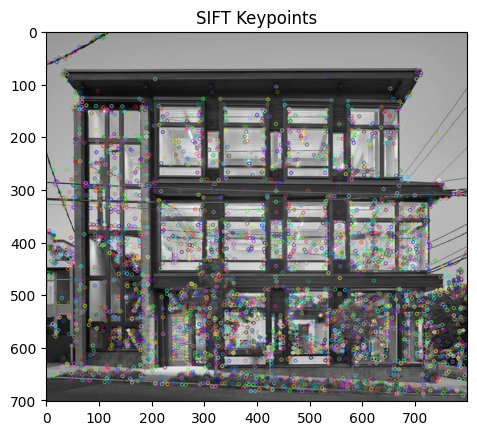

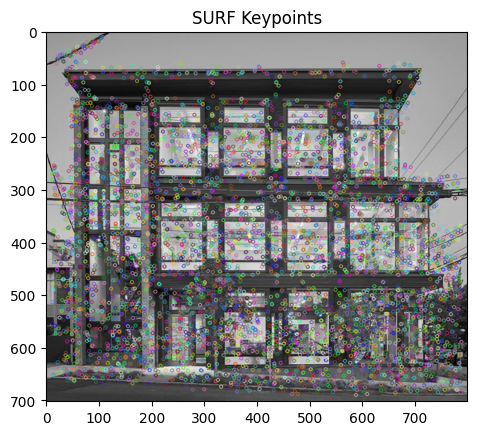

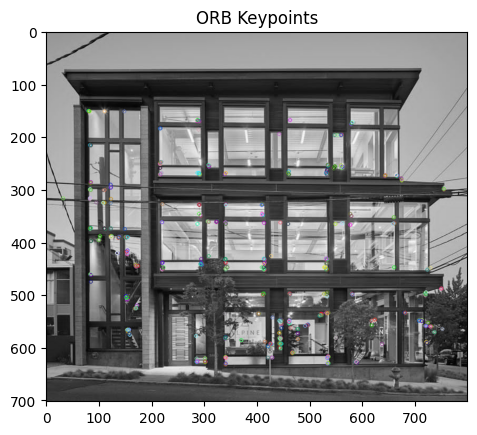

True

In [12]:
# Initialize SIFT
sift = cv2.SIFT_create()
keypoints1_sift, descriptors1_sift = sift.detectAndCompute(image1, None)
keypoints2_sift, descriptors2_sift = sift.detectAndCompute(image2, None)

# Visualize SIFT keypoints
sift_keypoints_image = cv2.drawKeypoints(image1, keypoints1_sift, None)
plt.imshow(cv2.cvtColor(sift_keypoints_image, cv2.COLOR_BGR2RGB))
plt.title('SIFT Keypoints')
plt.show()

# Initialize SURF (requires OpenCV contrib package)
surf = cv2.xfeatures2d.SURF_create()
keypoints1_surf, descriptors1_surf = surf.detectAndCompute(image1, None)
keypoints2_surf, descriptors2_surf = surf.detectAndCompute(image2, None)

# Visualize SURF keypoints
surf_keypoints_image = cv2.drawKeypoints(image1, keypoints1_surf, None)
plt.imshow(cv2.cvtColor(surf_keypoints_image, cv2.COLOR_BGR2RGB))
plt.title('SURF Keypoints')
plt.show()

# Initialize ORB
orb = cv2.ORB_create()
keypoints1_orb, descriptors1_orb = orb.detectAndCompute(image1, None)
keypoints2_orb, descriptors2_orb = orb.detectAndCompute(image2, None)

# Visualize ORB keypoints
orb_keypoints_image = cv2.drawKeypoints(image1, keypoints1_orb, None)
plt.imshow(cv2.cvtColor(orb_keypoints_image, cv2.COLOR_BGR2RGB))
plt.title('ORB Keypoints')
plt.show()


# Save keypoints visualization images
cv2.imwrite('sift_keypoints.jpg', cv2.drawKeypoints(image1, keypoints1_sift, None))
cv2.imwrite('surf_keypoints.jpg', cv2.drawKeypoints(image1, keypoints1_surf, None))
cv2.imwrite('orb_keypoints.jpg', cv2.drawKeypoints(image1, keypoints1_orb, None))


# Step 3: Feature Matching with Brute-Force and FLANN

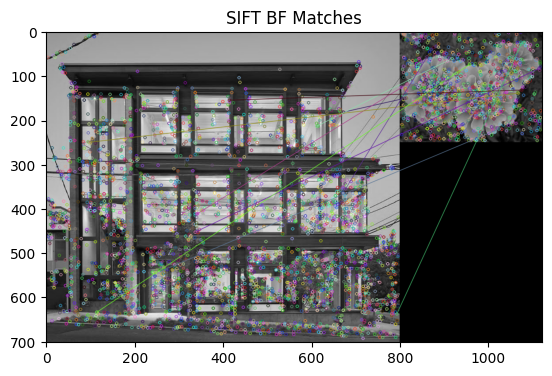

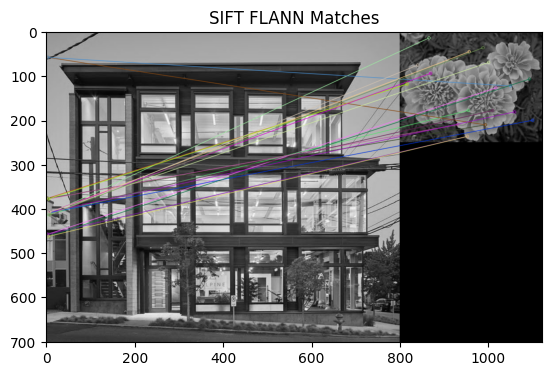

True

In [13]:
# Brute-Force Matcher for SIFT
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches_sift_bf = bf.match(descriptors1_sift, descriptors2_sift)
matches_sift_bf = sorted(matches_sift_bf, key=lambda x: x.distance)

# Visualize Brute-Force SIFT matches
sift_bf_img = cv2.drawMatches(image1, keypoints1_sift, image2, keypoints2_sift, matches_sift_bf[:10], None)
plt.imshow(cv2.cvtColor(sift_bf_img, cv2.COLOR_BGR2RGB))
plt.title('SIFT BF Matches')
plt.show()

# FLANN Matcher for SIFT
flann_index_kdtree = 1
index_params = dict(algorithm=flann_index_kdtree, trees=5)
search_params = dict(checks=50)  # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches_sift_flann = flann.knnMatch(descriptors1_sift, descriptors2_sift, k=2)

# Visualize FLANN matches
sift_flann_img = cv2.drawMatchesKnn(image1, keypoints1_sift, image2, keypoints2_sift, matches_sift_flann[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(cv2.cvtColor(sift_flann_img, cv2.COLOR_BGR2RGB))
plt.title('SIFT FLANN Matches')
plt.show()

# Drawing matches
sift_bf_img = cv2.drawMatches(image1, keypoints1_sift, image2, keypoints2_sift, matches_sift_bf[:10], None)
cv2.imwrite('sift_bf_match.jpg', sift_bf_img)

sift_flann_img = cv2.drawMatchesKnn(image1, keypoints1_sift, image2, keypoints2_sift, matches_sift_flann[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2.imwrite('sift_flann_match.jpg', sift_flann_img)


# Step 4: Image Alignment Using Homography

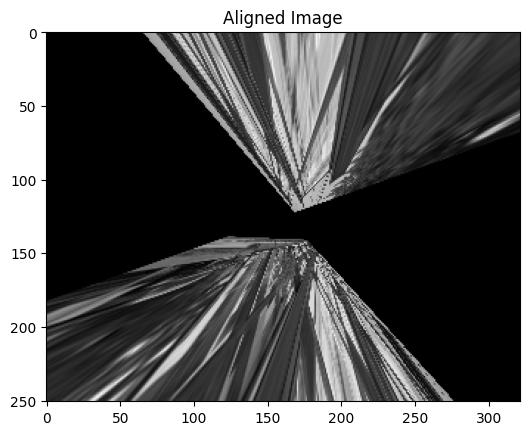

In [14]:
import numpy as np

# Use the matched keypoints to compute the homography matrix
src_pts = np.float32([keypoints1_sift[m.queryIdx].pt for m in matches_sift_bf]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2_sift[m.trainIdx].pt for m in matches_sift_bf]).reshape(-1, 1, 2)

# Compute the homography matrix
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Warp image1 to align with image2
aligned_image = cv2.warpPerspective(image1, H, (image2.shape[1], image2.shape[0]))
cv2.imwrite('aligned_image.jpg', aligned_image)

# Visualize aligned image
plt.imshow(cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB))
plt.title('Aligned Image')
plt.show()
